## Inference on IAA images of Dead Sea Scrolls to detect the bars
This notebook uses the trained model to detect bars in IAA images of the Dead Sea Scrolls. The detected bars are can be returned as a list of bounding boxes or visualized drawn bounding boxes around them on the image.

In [1]:
# import modules
import torch
import detectron2
import json
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os
# Retrieve the metadata catalog for the "bar_test" dataset
bar_test_metadata = MetadataCatalog.get("bar_test")


/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def bar_get_cfg():
    '''
    Loads the Faster R-CNN configuration file from the model zoo, merges it with additional settings specific to the bar 
    detection, and returns the resulting configuration as a ConfigNode object.
    
    Returns:
        ConfigNode: A ConfigNode object containing the configuration settings for the Faster R-CNN model.
    '''
    cfg = get_cfg()
    # merge in configuration file for model
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    # adjust configuration settings for bar detection
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.TEST.DETECTIONS_PER_IMAGE = 5
    return cfg


In [3]:
def detect_objects(image_path, model_path, threshold=0.90):
    '''
    Detects objects in an image using a specified model and returns the bounding boxes as a list.
    
    Args:
        image_path (str): The path to the image file.
        model_path (str): The path to the trained model file.
        threshold (float, optional): The confidence threshold above which to consider an object detected. Defaults to 0.90.
    
    Returns:
        list: A list of bounding boxes for the detected objects. Each bounding box is represented as a list of four floats 
              corresponding to the (x1, y1, x2, y2) coordinates of the top-left and height and width of the bounding box.
    '''
    setup_logger()
    
    # Get configuration settings for Faster R-CNN model specific to bar detection
    bar_cfg = bar_get_cfg()
    
    # Set threshold for the model
    bar_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    
    # Set path to the model
    bar_cfg.MODEL.WEIGHTS = model_path
    
    # Create predictor object with the updated configuration settings
    predictor = DefaultPredictor(bar_cfg)
    
    # Load image and use predictor to detect objects within the image
    im = cv2.imread(image_path)
    outputs = predictor(im)
    
    # Extract bounding boxes of detected objects and return as a list
    bounding_boxes = []
    for box in outputs["instances"].pred_boxes.tensor.tolist():
        bounding_boxes.append(box)
    return bounding_boxes


### Example using of detect_objects() function
This function uses the trained model stored in model_path to detect objects in the image located at image_path. The threshold argument specifies the confidence threshold for detection, with the default value set to 0.90.

The function returns a list of bounding boxes of detected objects in the image, where each bounding box is represented as a list of four coordinates: (x1, y1, h, w). These coordinates correspond to the top left x, y coordinates and height and width of the bounding box, respectively. The bounding_boxes variable stores this list of detected bounding boxes.

In [4]:
bounding_boxes = detect_objects(image_path = "bar_data/test_images/1094_2_recto_color.jpg", model_path = "output/model_final.pth")

/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
bounding_boxes

[[515.24267578125, 4580.193359375, 6162.42431640625, 5366.7158203125],
 [739.9039306640625, 16.021764755249023, 5456.57373046875, 702.810546875],
 [5968.0703125, 1483.0296630859375, 6385.44482421875, 3337.96630859375]]

In [6]:
def show_objects(image_path, model_path, threshold=0.90):
    '''
    Displays an image with bounding boxes drawn around any detected objects.

    Args:
        image_path (str): The path to the image to be processed.
        model_path (str): The path to the trained model to use for object detection.
        threshold (float, optional): The minimum confidence threshold for detected objects. Default is 0.90.

    Returns:
        None: Displays the image with bounding boxes drawn around any detected objects.
    '''
    setup_logger()
    # Get configuration for bar detection
    bar_cfg = bar_get_cfg()
    # Set threshold for model
    bar_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    # Load trained weights
    bar_cfg.MODEL.WEIGHTS = model_path
    # Create predictor
    predictor = DefaultPredictor(bar_cfg)
    # Load image
    im = cv2.imread(image_path)
    # Run inference on image
    outputs = predictor(im)
    # Visualize predictions
    v = Visualizer(im,
                   metadata=bar_test_metadata, 
                   scale=1, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # Display image with bounding boxes
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')

    return


### Example using of show_objects() function
This function takes an image path and a trained model path as inputs, along with an optional threshold value. It loads the specified image and trained model, runs inference on the image using the specified model, and then displays the image with bounding boxes drawn around any detected objects.

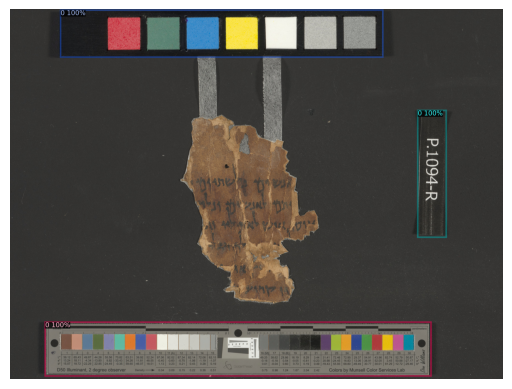

In [7]:
show_objects(image_path = "bar_data/test_images/1094_2_recto_color.jpg", model_path = "output/model_final.pth")

In [8]:
def increase_bbox_size(outputs, increase_pixels, image_shape):
    '''
    Increase the size of the bounding boxes in the given outputs.
    Args:
        outputs (dict): A dictionary containing the model's predictions.
        increase_pixels (int): The number of pixels to add to the edges of each bounding box.
        image_shape (tuple): A tuple containing the dimensions of the image in (height, width) format.

    Returns:
        dict: A dictionary containing the modified bounding boxes.
    '''
    # Access the bounding boxes from the outputs
    bboxes = outputs['instances'].pred_boxes.tensor.clone()
    # Increase the size of the bounding boxes
    bboxes[:, 0] -= increase_pixels # xmin
    bboxes[:, 1] -= increase_pixels # ymin
    bboxes[:, 2] += increase_pixels*2 # xmax
    bboxes[:, 3] += increase_pixels*2 # ymax
    # Check if any coordinates are outside of the image bounds
    bboxes[:, 0] = torch.clamp(bboxes[:, 0], min=0) # xmin
    bboxes[:, 1] = torch.clamp(bboxes[:, 1], min=0) # ymin
    bboxes[:, 2] = torch.clamp(bboxes[:, 2], max=image_shape[1]) # xmax
    bboxes[:, 3] = torch.clamp(bboxes[:, 3], max=image_shape[0]) # ymax
    # Update the bounding boxes in the outputs
    outputs['instances'].pred_boxes.tensor = bboxes
    # Return the modified outputs
    return outputs

### Inference on full set of images

In [10]:
# Set the detection threshold and model path
threshold = 0.95
model_path = 'output/model_final.pth'

# Initialize the object detection model
setup_logger()
bar_cfg = bar_get_cfg()
bar_test_metadata = MetadataCatalog.get("bar_test")
bar_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
bar_cfg.MODEL.WEIGHTS = model_path
predictor = DefaultPredictor(bar_cfg)

# Create directory for the visualized outputs
if not os.path.exists('output/visualized_predictions'):
    os.makedirs('output/visualized_predictions')

# Create an empty COCO annotations dictionary
coco = {"images": [], "annotations": [], "categories": []}

# Iterate through the images
for file_name in os.listdir("bar_data/test_images"):
    print("Processing " + file_name)
    # Load the image
    img = cv2.imread(f"bar_data/test_images/{file_name}")
    # Predict the bounding boxes
    outputs = predictor(img)
    # Increase bbox size by at each direction
    outputs = increase_bbox_size(outputs, 30, img.shape[:2])
    # Save the visualization
    v = Visualizer(img,
                   metadata=bar_test_metadata, 
                   scale=1, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite('output/visualized_predictions/'+file_name, out.get_image())
    # Get the predicted bounding boxes
    bboxes = outputs["instances"].pred_boxes.tensor.tolist()
    # Get the predicted class labels
    labels = outputs["instances"].pred_classes.tolist()
    # Add the image to the COCO annotations dictionary
    coco["images"].append({"file_name": file_name, "id": len(coco["images"]) + 1})
    # Add the predicted bounding boxes to the COCO annotations dictionary
    for bbox, label in zip(bboxes, labels):
        coco["annotations"].append({"image_id": len(coco["images"]), "bbox": bbox, "category_id": label})
    # Add the category labels to the COCO annotations dictionary
    if len(coco["categories"]) == 0:
        for label in set(labels):
            coco["categories"].append({"id": label, "name": f"class_{label}"})

# Save the COCO annotations to a json file
with open("output/test_predictions.json", "w") as f:
    json.dump(coco, f)

Processing 1094_2_recto_color.jpg
Processing 1095_4_recto_color.jpg
Processing 998_7_recto_color.jpg
Processing 1108_1_verso_color.jpg
Processing 1108_5_recto_color.jpg
Processing 998_8_recto_color.jpg
Processing 1108_9_verso_color.jpg
Processing 998_10_verso_color.jpg
Processing 1108_2_recto_color.jpg
Processing 1108_6_verso_color.jpg
Processing 998_7_verso_color.jpg
Processing 1108_6_recto_color.jpg
Processing 1108_2_verso_color.jpg
Processing 998_10_recto_color.jpg
Processing 1108_9_recto_color.jpg
Processing 1094_5_recto_color.jpg
Processing 1108_8_verso_color.jpg
Processing 1108_3_recto_color.jpg
Processing 1108_7_verso_color.jpg
Processing 1095_2_recto_color.jpg
Processing 1101_5_verso_color.jpg
Processing 998_6_recto_color.jpg
Processing 1108_4_recto_color.jpg
Processing 998_9_recto_color.jpg
Processing 1108_7_recto_color.jpg
Processing 1095_2_verso_color.jpg
Processing 1108_3_verso_color.jpg
Processing 1108_8_recto_color.jpg
Processing 1094_5_verso_color.jpg
Processing 1094_2_v